# RAP - Roll Angle Predictor
The task is to build a regression model, which is able to predict the roll angle based on the given plane picture.

In [18]:
%matplotlib notebook
import keras
from keras import layers
from keras import models
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os, shutil
import IPython.display as display
from PIL import Image
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

First, i created paths to my folders contain data and images:

In [2]:
base_dir = 'C:/Users/mikozyra/Documents/Exercises/Exercise_3'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
csv_dir = os.path.join(base_dir, 'plane_data.csv')

with open('C:/Users/mikozyra/Documents/Exercises/Exercise_3/plane_data.csv') as csvfile:
    plane = csv.reader(csvfile)


In [3]:
data = pd.read_csv(csv_dir, error_bad_lines=False,sep=';',dtype={'angle': np.float64})

print(data)

     folder          filename      angle
0     train  samolot00001.png -45.000000
1     train  samolot00003.png -44.774989
2     train  samolot00005.png -44.549978
3     train  samolot00007.png -44.324966
4     train  samolot00009.png -44.099955
...     ...               ...        ...
9995  train  samolot19991.png  43.987449
9996  train  samolot19993.png  44.212461
9997  train  samolot19995.png  44.437472
9998  train  samolot19997.png  44.662483
9999  train  samolot19999.png  44.887494

[10000 rows x 3 columns]


## Sequential model:

In [53]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1))

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Note that the last dense (dense_4) doesn't have activization function, because we need to get continuous values from [-50,50]. According to book Francois Chollet's, one of the best set hiperparametres for linear regression are
- 'mse' as loss function - Mean Squared Error
- 'rmsprop' as optimizer 
- 'mae' as metrics  - Mean Absolute Error

Ofcourse, it is only suggestion but (as u will see soon) it works well.

In [184]:
#from keras import optimizers
model.compile(loss='mse',
              optimizer='rmsprop',
              #optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['mae'])

Importing images and convert them to tensors.

In [4]:
fnames_train = [os.path.join(train_dir, fname) for fname in os.listdir(train_dir)]

fnames_test =  [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]

# Wczytujemy obraz i zmieniamy jego rozdzielczość.
img_train = [image.load_img(img_path, target_size=(150, 150)) for img_path in fnames_train]

img_test = [image.load_img(img_path, target_size=(150, 150)) for img_path in fnames_test]


In [5]:
# Zamieniamy obraz w tablicę Numpy o kształcie (150, 150, 3).
x_train = [image.img_to_array(img_tmp) for img_tmp in img_train]

x_test = [image.img_to_array(img_tmp) for img_tmp in img_test]

In [6]:
#from array import array.fromlist 
x_train = np.array(x_train)
x_test = np.array(x_test)

Look at shape of tensor:

In [7]:
print(x_train.shape)

(9600, 150, 150, 3)


Vector of labels:

In [8]:
y_train = data.angle[:9600]
y_train = np.array(y_train)

y_test = data.angle[9600:]
y_test = np.array(y_test)

Dividing training data (9600) into training data (7680) and validation data (1920)

In [9]:
val_split = 0.2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split)

Visualization of random three images from training data:

<IPython.core.display.Javascript object>


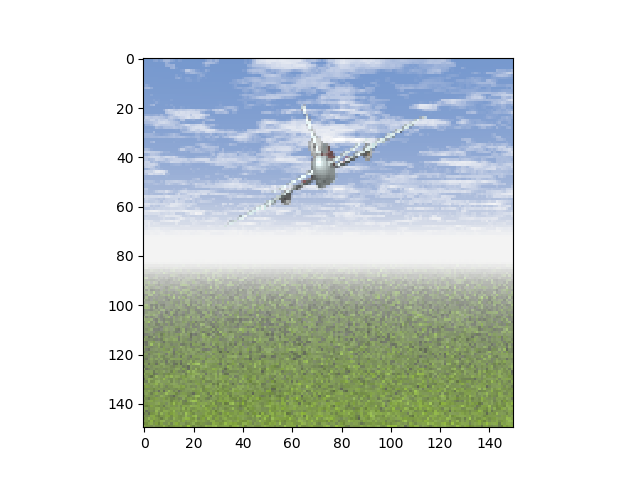

the roll angle: -22.41337067


<IPython.core.display.Javascript object>


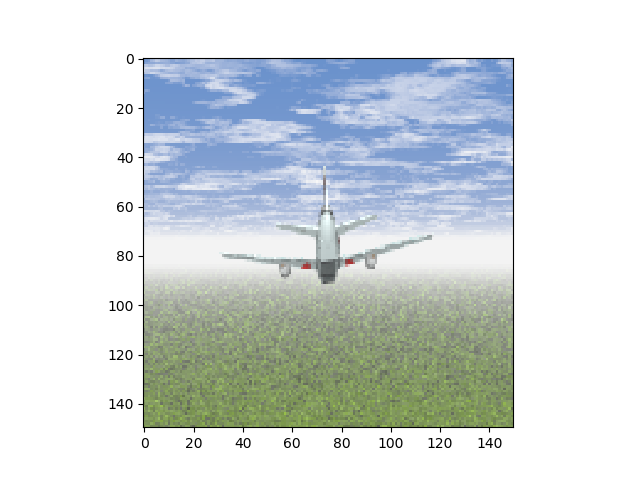

the roll angle: -4.007450373


<IPython.core.display.Javascript object>


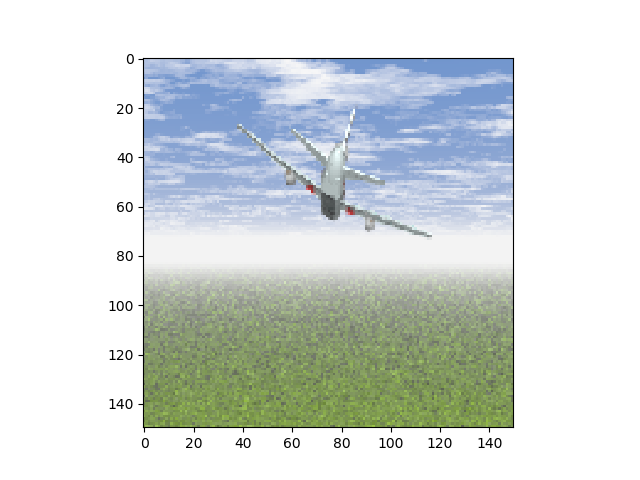

the roll angle: 23.479924


In [12]:
plt.figure(4)
imgplot = plt.imshow(image.array_to_img(x_train[5]))
plt.show()
print('the roll angle:', y_train[5])

plt.figure(2)
imgplot = plt.imshow(image.array_to_img(x_train[3]))
plt.show()
print('the roll angle:', y_train[3])

plt.figure(3)
imgplot = plt.imshow(image.array_to_img(x_train[10]))
plt.show()
print('the roll angle:', y_train[10])

In [17]:
#print(x_train.shape)
#print(y_train.shape)
#print(x_val.shape)
#print(y_val.shape)

In [47]:
#datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
datagen = ImageDataGenerator(rescale=1/255.)

training_generator = datagen.flow(x_train, y_train, batch_size=48)
validation_generator = datagen.flow(x_val, y_val, batch_size=48)

test_generator = datagen.flow(x_test,y_test,batch_size=20, shuffle=False)
#training_generator = datagen.flow(x_train, y_train, batch_size=96)


It is important for ImageDataGenerator to define parametr **steps_per_epoch** which is total number of steps (batches of samples)before declaring one epoch finished and starting the next epoch. It is equal to the number of samples in your dataset divided by the batch size.

In [20]:
print('Steps per epoch for training generator:', 7680/48)
print('Steps per epoch for validation generator:', 1920/48)

Steps per epoch for training generator: 160.0
Steps per epoch for validation generator: 40.0


In [21]:
#for data_batch, labels_batch in training_generator:
#    print('Shape of inputs:', data_batch.shape)
#    print('Shape of labels:', data_batch.shape)
#    print('i.e. value of label:', labels_batch[1])
#    break

In [187]:
history = model.fit_generator(
      training_generator,
      steps_per_epoch=7680/48,#160
      epochs=50,
      validation_data=validation_generator,
      validation_steps=1920/48 #40
)

Epoch 1/50
160/160 [==============================] - 346s 2s/step - loss: 150.5414 - mean_absolute_error: 7.7641 - val_loss: 77.8640 - val_mean_absolute_error: 7.3914
Epoch 2/50
160/160 [==============================] - 349s 2s/step - loss: 33.5361 - mean_absolute_error: 4.1989 - val_loss: 6.7502 - val_mean_absolute_error: 2.0409
Epoch 3/50
160/160 [==============================] - 350s 2s/step - loss: 23.5725 - mean_absolute_error: 3.3522 - val_loss: 8.4560 - val_mean_absolute_error: 2.3180
Epoch 4/50
160/160 [==============================] - 341s 2s/step - loss: 21.1004 - mean_absolute_error: 3.1781 - val_loss: 3.6787 - val_mean_absolute_error: 1.5086
Epoch 5/50
160/160 [==============================] - 336s 2s/step - loss: 12.4311 - mean_absolute_error: 2.5935 - val_loss: 11.3474 - val_mean_absolute_error: 2.7296
Epoch 6/50
160/160 [==============================] - 334s 2s/step - loss: 12.3304 - mean_absolute_error: 2.5772 - val_loss: 17.1870 - val_mean_absolute_error: 3.4557


In [15]:
#model.save('plane1_20.h5')#20 epoch
#model.save('plane_win_rap.h5')
from keras.models import load_model
model_path = os.path.join(base_dir, 'plane_win_rap.h5')
model = load_model(model_path)

Visualization of goodness of fitting:

In [16]:
history_dict = history.history
history_dict.keys()

NameError: name 'history' is not defined

In [22]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='mae')
plt.plot(epochs, val_mae, 'b', label='val_mae')
plt.title('Mean Absolute Error for training and validation data')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='mse')
plt.plot(epochs, val_loss, 'b', label='val_mse')
plt.title('Mean Squared Error')
plt.legend()

plt.show()

NameError: name 'history' is not defined

Nice! Lets check it for testing data:

In [30]:
test_loss, test_mae = model.evaluate_generator(test_generator, steps = 20)
print('MSE of testing data:', test_loss)
print('MAE of testing data:', test_mae)

MSE of testing data: 1.9794561818242074
MAE of testing data: 1.11058167219162


In [48]:
#from keras import predict_generator 
est_test = model.predict_generator(test_generator, steps = 20)

In [62]:
df = pd.DataFrame(data=est_test)
df.columns=['estimated']
df['real']=y_test
print(df)
#y_test = np.array(y_test)
#est_test = np.array(est_test)
#print(len(est_test))
#print(len(y_test))
#print(est_test[:3])
#print(y_test[100:103])

     estimated       real
0   -42.370888 -44.891995
1   -42.604763 -44.666983
2   -42.480347 -44.441972
3   -42.098740 -44.216961
4   -42.218666 -43.991950
..         ...        ...
395  41.508659  43.987449
396  41.700760  44.212461
397  42.066833  44.437472
398  41.804329  44.662483
399  41.655308  44.887494

[400 rows x 2 columns]


<IPython.core.display.Javascript object>


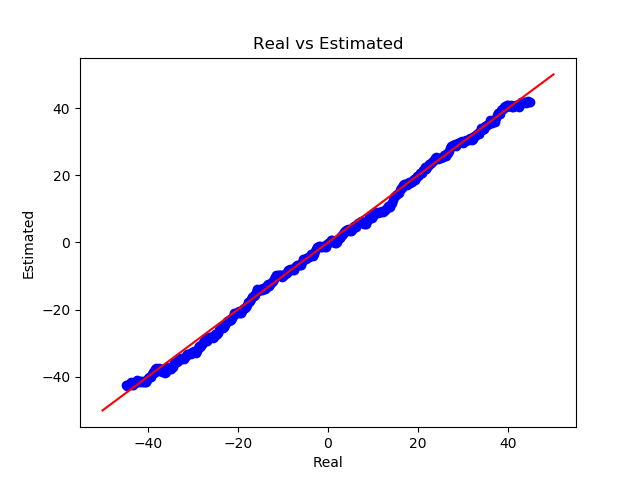

In [50]:

# Create data
x = y_test
y = est_test
colors = ('blue')
#area = np.pi*3

# Plot
plt.scatter(x, y, c=colors)
plt.title('Real vs Estimated')
plt.xlabel('Real')
plt.ylabel('Estimated')
plt.plot([-50, 50], [-50, 50], 'k-', color = 'r')
plt.show()